- **This code is a preparation for computing the CL-DRTO solution using a scenario-based stochastic programming approach and its implementation in the plant.**

Here, we code:
- Decrease the size of the finite element of the backward Euler method while keeping the input discretization the same 
- Compare the solution with an ODE integrator
- Apply the changes to a CLDRTO implementarion using a constrained MPC at DRTO level (strategy 3 from preliminaries 1)

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: August 2023

[1. Model and Simulation Parameters](#sec1) <br>
[2. Optimizing dynamic model using Backward Euler](#sec2) <br>
[3. Integrating dynamic model using ODE](#sec3) <br>
[4. CLDRTO Dynamic optimization test](#sec4) <br>
[5. Relaxation terms in the OF tuning](#sec5) <br>

In [1]:
using LinearAlgebra, JuMP, Ipopt, Plots, DifferentialEquations

<a id="sec1"></a>

# Model and simulation parameter

- Simulation parameters (see original parameters in Monolithic and Decomposed CLDRTO file)

In [2]:
# Simulation sampling time
dt = 1.0 #[s]

# Plant simulation time span
tspan = (0.0,dt)

# Optimization horizon
ndrto = 5 

# Optimization horizon
Δdrto = 3 

# integration (BE) sampling time
n_fe_dt = 5 # number of finite elements/simulation sampling time 

# finite element length
h = dt/n_fe_dt 

# number of finite elements 
nfe = ndrto*n_fe_dt

# number of components
nc = 3 #[-]
# number of inputs
nu = 2 #[-]
# number of reactors
nrt = 2 #[-]
# number of reactions
nrc = 2 #[-]
# number of MPCs
numpc = 2 

# initial value
C0 = [0.124287 0.216517;
    19.725 19.659;
    0.150668 0.124504]
T0 = [341.7216268417903 331.0792925101132]

# "algebraic states"
C_in0 = [20.0 10.0621;
          0 9.86252;
          0 0.0753341]
T_in0 = [299.99999999998846 320.8608134932841]
Tj_out0 = [316.6886507367161 297.43171700404525]

# "inputs"
Q0 = 0.2
Qm0 = 0.2

# initial value of u
u0 = [Q0 Qm0]

# States (algebraic and differential): CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out
x0 = [C0[1,1], C0[2,1], C0[3,1],T0[1],Tj_out0[1],C0[1,2], C0[2,2], C0[3,2],T0[2],Tj_out0[2]];

- Model Parameters

In [3]:
# feed to reactor 1 concentrations c = (A,B,C)
C1_in = [20.0, 0, 0] #[kmol/m3]

# temperature of feed to reactor 1
T1_in = 300.0 #[K]

# feed to mixer concentration c = (A,B,C)
Cm_in = [20.0, 0, 0]

# temperature of feed to mixer
Tm_in = 300.0 #[K]

# feed flowrate of cooling water to reactor jacket r = (1,2)
Qj_in = [0.7, 0.7] #[m3/s]

# cooling water temperature to reactor jacket r = (1,2)
Tj_in = [300.0, 275.0] #[m3/s]

# reactor volumetric holdup r = (1,2)
V = [5.0, 5.0] #[m3]

# heat transfer coefficient
Ua = [0.35, 0.35] #[m3/s]

# reaction rate constant e = (I,II)
k0 = [2.7e8, 160.0] #[1/s]

# reaction activation energy e = (I,II)
ER = [6000.0, 4500.0] #[K]

# heat of reaction e = (I,II)
dH_pcp = -[5.0, 5.0] #[m3 K/kmol] 

# stochiometric matrix 
Ms = [-1 0;
       1 -1;
       0 1];

- Economic Optimization Problem Parameters

In [4]:
# feed supply limitation
Qf_max = 0.8 #[m3/s] 

# safety restriction (avoiding temperature run away) -- (350)
Tr_max = 360 #[K]

# product specifications
cA2_max = 0.3 #[kmol/m3]

# max cooling water outlet temperature r = (1,2) ([340, 310])
Tj_max = [340, 310] #[K]

# min feed to reactor 1
Q_min = 0.05 #[m3/s]

# min feed to mixer
Qm_min = 0.05; #[m3/s]

# Output bounds (T1, T2)
yMin = [100.0 100.0] #K
yMax = [350.0 350.0] #K

# Setpoint bounds (T1, T2)
yspMin = [100.0 100.0] #K
yspMax = [360.0 360.0] #K

# Input bounds (Q1, Qm)
uMin = [0.050 0.050] #K
uMax = [0.805 0.800]; #K

- Steady-state optimal solution

In [5]:
# concentration related variables
C0_star = [0.114545 0.174342;
    19.7379 19.6938;
    0.147529 0.13187]

T0_star = [350.00000000404816 337.5000000227455]
T_in0_star = [300.0 327.5923855099112]
Tj_out0_star = [320.00000000161924 300.0000000090982]
Q0_star = [0.27907949788513375 0.5057183218310063]
Qm0_star = 0.22663882394587254

solSS = Dict('C' => C0_star,
             'T' => T0_star,
             'I' => T_in0_star, 
             'J' => Tj_out0_star,
             'Q' => Q0_star,
             'M' => Qm0_star);

- Preparing Orthogonal Collocation

In [6]:
# Parameters for orthogonal collocation
#  Radau Collocation Points 1st degree polynomial == Backward Euler
radau  = [0.0 1.00000]

# number of collocation points (initial point is also considered)
ncp = length(radau) 

# Collocation parameters and radau time series
colmat = [-1.0 -1.0;
          1.0 1.0];        

<a id="sec2"></a>

# Integrating model using Backward Euler

In [7]:
# JuMP model
m_drto = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_drto, "warm_start_init_point", "yes")
set_optimizer_attribute(m_drto, "print_level", 5)

# Set up variables
@variables(m_drto, begin
    C[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0           # [kmol/m3] concentration (diff states)
    Cdot[1:nc, 1:nrt, 1:nfe, 1:ncp]            # [kmol/m3/s] concentration (time derivative)
    T[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt]      # [K] reactor temperature (diff states)
    Tdot[rt=1:nrt, 1:nfe, 1:ncp]               # [K/s] reactor temperature (time derivative)
    J[1:nfe, 1:ncp]                            # [$] objective function (as diff state)
    Jdot[1:nfe, 1:ncp]                         # [$/s] objective function integrand
    C_in[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0        # [kmol/m3] inlet concentration (alg. states)
    T_in[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt]   # [K] inlet temperature (alg. states)    
    Tj_out[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt] # [K] jacket temperature (alg. states)    
    Q_min ≤ Q[1:nrt, 1:ndrto] ≤ Qf_max    # [m3/s] flowrate to reactor
    Qm_min ≤ Qm[1:ndrto] ≤ Qf_max         # [m3/s] flowrate to mixer
end)


# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for ii in 1:nfe
    for jj in 1:ncp
        for rr in 1:nrt
            for cc in 1:nc
                # concentration related variables
                set_start_value(C[cc,rr,ii,jj], C0_star[cc,rr]) 
                set_start_value(C[cc,rr,ii,jj], C0_star[cc,rr]) 
            end # components loop
            
            # temperature related variables
            set_start_value(T[rr,ii,jj], T0_star[rr]) 
            set_start_value(T_in[rr,ii,jj], T_in0_star[rr])
            set_start_value(Tj_out[rr,ii,jj], Tj_out0_star[rr])
            
        end # reactors loop
    end # collocation points loop
end

for ii in 1:ndrto
    # MV's
    for rr in 1:nrt
        set_start_value(Q[rr,ii], Q0_star[rr])  
    end
    set_start_value(Qm[ii], Qm0_star) 
end # finite elements loop

@NLexpressions(m_drto, begin
    # [1/s] reaction rate
    k[rt = 1:nrt, rc = 1:nrc, ii = 1:nfe, jj = 1:ncp], k0[rc]*exp(-ER[rc]/T[rt,ii,jj])
    #[m3 K/s] cooling rate
    # approximate model *approximating logarithm temperature
    qcool[rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Ua[rt]*(T[rt,ii,jj] - (0.5*(Tj_out[rt,ii,jj] + Tj_in[rt])))
end)

#Set up the constraints
@NLconstraints(m_drto, begin
    #########
    # MODEL #
    #########    
    # reactor
    r_cmb[co = 1:nc, rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Cdot[co,rt,ii,jj] == (C_in[co,rt,ii,jj] - C[co,rt,ii,jj])*Q[rt,cld(ii,n_fe_dt)]/V[rt] + sum(Ms[co,rc]*k[rt,rc,ii,jj]*C[rc,rt,ii,jj] for rc in 1:nrc) 
    r_eb[rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], Tdot[rt,ii,jj] == (T_in[rt,ii,jj] - T[rt,ii,jj])*Q[rt,cld(ii,n_fe_dt)]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,ii,jj]*C[rc,rt,ii,jj] for rc in 1:nrc) - qcool[rt,ii,jj]/V[rt]
    # mixer
    m_mb[ii = 1:ndrto], 0 == Q[1,ii] + Qm[ii] - Q[2,ii]
    m_cmb[co = 1:nc,ii = 1:nfe,jj = 1:ncp], 0 == Q[1,cld(ii,n_fe_dt)]*C[co,1,ii,jj] + Qm[cld(ii,n_fe_dt)]*Cm_in[co] - Q[2,cld(ii,n_fe_dt)]*C_in[co,2,ii,jj]
    m_eb[ii = 1:nfe,jj = 1:ncp], 0 == Q[1,cld(ii,n_fe_dt)]*T[1,ii,jj] + Qm[cld(ii,n_fe_dt)]*Tm_in - Q[2,cld(ii,n_fe_dt)]*T_in[2,ii,jj]
    # jacket
    j_eb[rt = 1:nrt, ii = 1:nfe, jj = 1:ncp], 0 == Qj_in[rt]*(Tj_out[rt,ii,jj] - Tj_in[rt]) - qcool[rt,ii,jj]
    # objective function
    JInteg[ii = 1:nfe, jj = 1:ncp], Jdot[ii,jj] == 10*(Q[1,cld(ii,n_fe_dt)]*C_in[1,1,ii,jj] + Qm[cld(ii,n_fe_dt)]*Cm_in[1] - Q[2,cld(ii,n_fe_dt)]*(C[1,2,ii,jj] + C[3,2,ii,jj])) - 0.01*qcool[1,ii,jj] - qcool[2,ii,jj] - 0.1*Q[1,cld(ii,n_fe_dt)] - 0.1*Qm[cld(ii,n_fe_dt)]
        
    #########################    
    # Collocation Equations #    
    #########################
    # initial point
    coll_C_0[co=1:nc, rt = 1:nrt], C[co,rt,1,1] == C0[co,rt] 
    coll_T_0[rt = 1:nrt], T[rt,1,1] == T0[rt]
    coll_J_0, J[1,1] == 0    
        
    # set up collocation equations 
    coll_C_n[co = 1:nc, rt = 1:nrt, ii = 1:nfe, jj = 2:ncp], sum(colmat[kk,jj]*C[co,rt,ii,kk] for kk in 1:ncp) - h*Cdot[co,rt,ii,jj] == 0 
    coll_T_n[rt = 1:nrt, ii = 1:nfe, jj = 2:ncp], sum(colmat[kk,jj]*T[rt,ii,kk] for kk in 1:ncp) - h*Tdot[rt,ii,jj] == 0
    coll_J_n[ii = 1:nfe, jj = 2:ncp], sum(colmat[kk,jj]*J[ii,kk] for kk in 1:ncp) - h*Jdot[ii,jj] == 0
        
    # continuinity equations
    coll_C_con[co = 1:nc, rt = 1:nrt, ii = 2:nfe], C[co,rt,ii,1] - C[co,rt,ii - 1,ncp] == 0 
    coll_T_con[rt = 1:nrt, ii = 2:nfe], T[rt,ii,1] - T[rt,ii - 1,ncp] == 0
    coll_J_con[ii = 2:nfe], J[ii,1] - J[ii - 1,ncp] == 0
        
    ###############
    # CONSTRAINTS #
    ###############
    # ! Enforcing only at the end of the finite element
    # safety restrictions
    g1[rt = 1:nrt, ii = 1:nfe], T[rt,ii,ncp] - Tr_max ≤ 0
    # product specifications (Concentration of A in reactor 2)
    g2[ii = 1:nfe], C[1,2,ii,ncp] - cA2_max ≤ 0
    # feed supply limitations
    g3[ii = 1:ndrto], Q[1,ii] + Qm[ii] - Qf_max ≤ 0
    # process limitations (others have been included when declaring variables): max cooling water outlet temperature
    g4[rt = 1:nrt, ii = 1:nfe], Tj_out[rt,ii,ncp] - Tj_max[rt] ≤ 0    
        
    ##############    
    # PARAMETERS #
    ##############
    p1[co = 1:nc,ii = 1:nfe,jj = 1:ncp], C_in[co,1,ii,jj] - C1_in[co] == 0
    p2[ii = 1:nfe,jj = 1:ncp], T_in[1,ii,jj] - T1_in == 0
    end)

# Set up objective function  
@NLobjective(m_drto, Min, -J[nfe,ncp])

In [8]:
# Solve the model
status = optimize!(m_drto)


# time series for plotting
t_be = Vector{Float64}(undef,nfe) 
for kk in 1:nfe
    t_be[kk] = h*kk
end

# time series for plotting
Q1_be = value.(Q[1,:])
Qm_be = value.(Qm)

Cr_be = Array{Float64}(undef,nc,nrt,nfe) 
Tr_be = Array{Float64}(undef,nrt,nfe)
Tj_be = Array{Float64}(undef,nrt,nfe)

for rt in 1:nrt
    for co in 1:nc
        Cr_be[co,rt,:] = value.(C[co,rt,:,ncp])
    end
    Tr_be[rt,:] = value.(T[rt,:,ncp])
    Tj_be[rt,:] = value.(Tj_out[rt,:,ncp])
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5681
Number of nonzeros in inequality constraint Jacobian.:      135
Number of nonzeros in Lagrangian Hessian.............:     5750

Total number of variables............................:     1415
                     variables with only lower bounds:      900
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1405
Total number of inequality co

<a id="sec3"></a>

# Integrating model using ODE Integrator

Preparing integrator

In [9]:
function twoCSTRS_dae!(dx, x, p, t)
    CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out = x
    Q1,Qm = p
    
    # reactor 1
    dx[1] = (C1_in[1] - CA1)*Q1/V[1] - k0[1]*exp(-ER[1]/T1)*CA1 
    dx[2] = (C1_in[2] - CB1)*Q1/V[1] + k0[1]*exp(-ER[1]/T1)*CA1 - k0[2]*exp(-ER[2]/T1)*CB1
    dx[3] = (C1_in[3] - CC1)*Q1/V[1] + k0[2]*exp(-ER[2]/T1)*CB1
    dx[4] = (T1_in - T1)*Q1/V[1] - dH_pcp[1]*k0[1]*exp(-ER[1]/T1)*CA1 - dH_pcp[2]*k0[2]*exp(-ER[2]/T1)*CB1 - Ua[1]*(T1 - (0.5*(Tj1_out + Tj_in[1])))/V[1]
    dx[5] = Qj_in[1]*(Tj1_out - Tj_in[1]) - Ua[1]*(T1 - (0.5*(Tj1_out + Tj_in[1])))
    # reactor 2
    dx[6] = ((Q1*CA1 + Qm*Cm_in[1])/(Q1 + Qm) - CA2)*(Q1 + Qm)/V[2] - k0[1]*exp(-ER[1]/T2)*CA2 
    dx[7] = ((Q1*CB1 + Qm*Cm_in[2])/(Q1 + Qm) - CB2)*(Q1 + Qm)/V[2] + k0[1]*exp(-ER[1]/T2)*CA2 - k0[2]*exp(-ER[2]/T2)*CB2 
    dx[8] = ((Q1*CC1 + Qm*Cm_in[3])/(Q1 + Qm) - CC2)*(Q1 + Qm)/V[2] + k0[2]*exp(-ER[2]/T2)*CB2 
    dx[9] = ((Q1*T1 + Qm*Tm_in)/(Q1 + Qm) - T2)*(Q1 + Qm)/V[2] - dH_pcp[1]*k0[1]*exp(-ER[1]/T2)*CA2 - dH_pcp[2]*k0[2]*exp(-ER[2]/T2)*CB2 - Ua[2]*(T2 - (0.5*(Tj2_out + Tj_in[2])))/V[2]
    dx[10] = Qj_in[2]*(Tj2_out - Tj_in[2]) - Ua[2]*(T2 - (0.5*(Tj2_out + Tj_in[2])))
    
    nothing
end

# mass matrix to determine algebraic equations
M = [1. 0 0 0 0 0 0 0 0 0;
     0 1. 0 0 0 0 0 0 0 0;
     0 0 1. 0 0 0 0 0 0 0;
     0 0 0 1. 0 0 0 0 0 0;
     0 0 0 0 0 0 0 0 0 0;
     0 0 0 0 0 1. 0 0 0 0;
     0 0 0 0 0 0 1. 0 0 0;
     0 0 0 0 0 0 0 1. 0 0;
     0 0 0 0 0 0 0 0 1. 0;
     0 0 0 0 0 0 0 0 0 0]

ode_fun_mm = ODEFunction(twoCSTRS_dae!,mass_matrix=M);

In [10]:
# time series for plotting
t_integr = Vector{Float64}(undef,ndrto) 
for kk in 1:ndrto
    t_integr[kk] = dt*kk
end

# time series for plotting
Cr_integr = Array{Float64}(undef,nc,nrt,ndrto) 
Tr_integr = Array{Float64}(undef,nrt,ndrto)
Tj_integr = Array{Float64}(undef,nrt,ndrto)

# preparing simulation (inputs are kept constant)
xk = x0

for kk = 1:ndrto
    
    ode_prob_mm = ODEProblem(ode_fun_mm,xk,tspan,[Q1_be[kk] Qm_be[kk]]);
    sol =  solve(ode_prob_mm, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);
    
    # saving data
    Cr_integr[:,1,kk] = sol.u[end][1:3]
    Tr_integr[1,kk] = sol.u[end][4]
    Tj_integr[1,kk] = sol.u[end][5]
    Cr_integr[:,2,kk] = sol.u[end][6:8]
    Tr_integr[2,kk] = sol.u[end][9]
    Tj_integr[2,kk] = sol.u[end][10]
    
    # loop
    xk = sol.u[end]
end 

## Comparing trajectories

Concentration

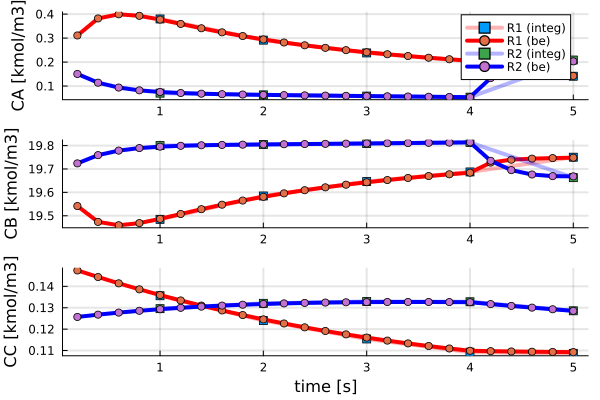

In [11]:
gr()

p1 = plot(t_integr,Cr_integr[1,1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="CA [kmol/m3]")
p1 = plot!(t_be,Cr_be[1,1,:],linewidth=4,linecolor = :red,marker=:circle)
p1 = plot!(t_integr,Cr_integr[1,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue)
p1 = plot!(t_be,Cr_be[1,2,:],linewidth=4,linecolor = :blue,marker=:circle)

p1.series_list[1][:label] = "R1 (integ)"
p1.series_list[2][:label] = "R1 (be)"
p1.series_list[3][:label] = "R2 (integ)"
p1.series_list[4][:label] = "R2 (be)"

p2 = plot(t_integr,Cr_integr[2,1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="CB [kmol/m3]",legend=false)
p2 = plot!(t_be,Cr_be[2,1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p2 = plot!(t_integr,Cr_integr[2,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p2 = plot!(t_be,Cr_be[2,2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

p3 = plot(t_integr,Cr_integr[3,1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="CC [kmol/m3]",legend=false)
p3 = plot!(t_be,Cr_be[3,1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p3 = plot!(t_integr,Cr_integr[3,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p3 = plot!(t_be,Cr_be[3,2,:],linewidth=4,linecolor = :blue,marker=:circle,xaxis="time [s]",legend=false)

g1 = plot(p1,p2,p3,layout=(3,1))
display(g1)

Temperature

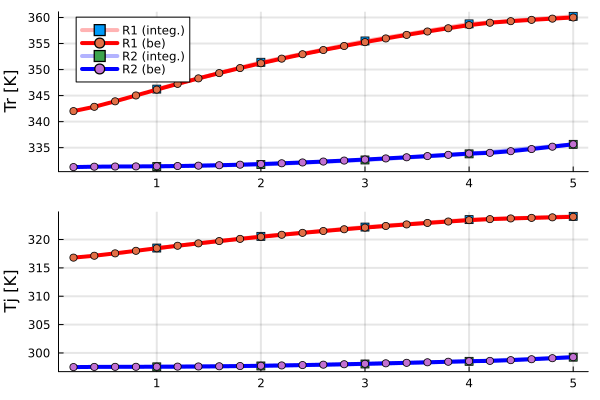

In [12]:
gr()

p4 = plot(t_integr,Tr_integr[1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Tr [K]")
p4 = plot!(t_be,Tr_be[1,:],linewidth=4,linecolor = :red,marker=:circle)
p4 = plot!(t_integr,Tr_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue)
p4 = plot!(t_be,Tr_be[2,:],linewidth=4,linecolor = :blue,marker=:circle)

p4.series_list[1][:label] = "R1 (integ.)"
p4.series_list[2][:label] = "R1 (be)"
p4.series_list[3][:label] = "R2 (integ.)"
p4.series_list[4][:label] = "R2 (be)"

p5 = plot(t_integr,Tj_integr[1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="Tj [K]",legend=false)
p5 = plot!(t_be,Tj_be[1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p5 = plot!(t_integr,Tj_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p5 = plot!(t_be,Tj_be[2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

g2 = plot(p4,p5,layout=(2,1))
display(g2)

## Computing the residuals

In [13]:
# time series for plotting
Cr_res = Array{Float64}(undef,nc,nrt,ndrto) 
Tr_res = Array{Float64}(undef,nrt,ndrto)
Tj_res = Array{Float64}(undef,nrt,ndrto)

for kk = 1:ndrto
    # Computing residual
    Cr_res[:,:,kk] = abs.(Cr_integr[:,:,kk] - Cr_be[:,:,kk*n_fe_dt])
    Tr_res[:,kk] = abs.(Tr_integr[:,kk] - Tr_be[:,kk*n_fe_dt])
    Tj_res[:,kk] = abs.(Tj_integr[:,kk] - Tj_be[:,kk*n_fe_dt])
end 

Plotting

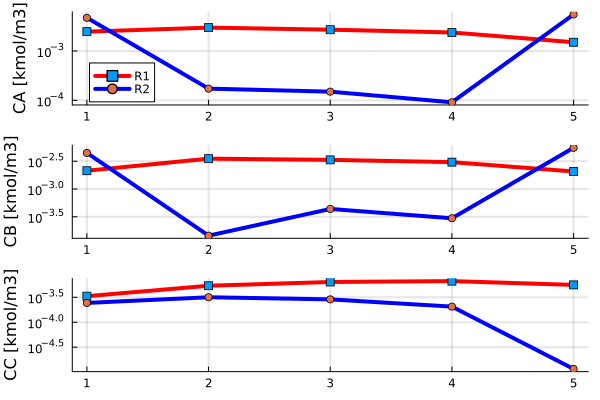

In [14]:
gr()

p6 = plot(t_integr,Cr_res[1,1,:],linewidth=4,linecolor = :red,marker=:square,gridlinewidth=2,yscale=:log10,yaxis="CA [kmol/m3]")
p6 = plot!(t_integr,Cr_res[1,2,:],linewidth=4,linecolor = :blue,marker=:circle)

p6.series_list[1][:label] = "R1"
p6.series_list[2][:label] = "R2"

p7 = plot(t_integr,Cr_res[2,1,:],linewidth=4,linecolor = :red,marker=:square,gridlinewidth=2,yscale=:log10,yaxis="CB [kmol/m3]",legend=false)
p7 = plot!(t_integr,Cr_res[2,2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

p8 = plot(t_integr,Cr_res[3,1,:],linewidth=4,linecolor = :red,marker=:square,gridlinewidth=2,yscale=:log10,yaxis="CC [kmol/m3]",legend=false)
p8 = plot!(t_integr,Cr_res[3,2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

g3 = plot(p6,p7,p8,layout=(3,1))
display(g3)

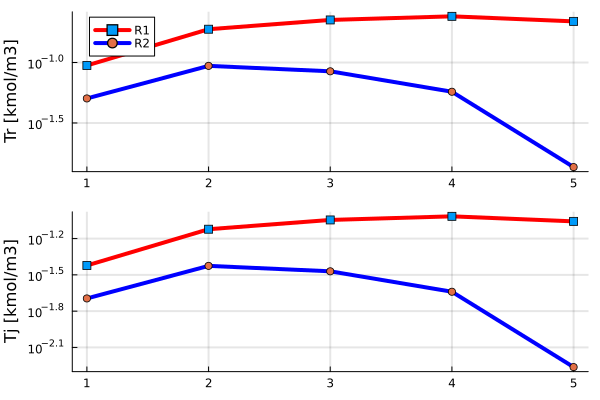

In [15]:
gr()

p9 = plot(t_integr,Tr_res[1,:],linewidth=4,linecolor = :red,marker=:square,gridlinewidth=2,yscale=:log10,yaxis="Tr [kmol/m3]")
p9 = plot!(t_integr,Tr_res[2,:],linewidth=4,linecolor = :blue,marker=:circle)

p9.series_list[1][:label] = "R1"
p9.series_list[2][:label] = "R2"

p10 = plot(t_integr,Tj_res[1,:],linewidth=4,linecolor = :red,marker=:square,gridlinewidth=2,yscale=:log10,yaxis="Tj [kmol/m3]",legend=false)
p10 = plot!(t_integr,Tj_res[2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

g4 = plot(p9,p10,layout=(2,1))
display(g4)

<a id="sec4"></a>

# Adding finer discretization to CLDRTO

- Parameters

In [16]:
##########
# MODELS #
##########
# reference for deviation variables
# MPC 1
T1_0_bar = 350.00000000404816
Q1_0_bar = 0.27907949788513375

# MPC 2
T2_0_bar = 337.5000000227455
Qm_0_bar = 0.22663882394587254

yref = [T1_0_bar T2_0_bar]
uref = [Q1_0_bar Qm_0_bar]

# Linear SISO model coefficients
# MPC1
a1_hat = 0.9444968979045645
b1_hat = 4.755754997301486

# MPC2
a2_hat = 0.9256356006985642
b2_hat = 5.70696857693315

# initial value of xMPC
xMPC0 = [T0[1] - T1_0_bar, T0[2] - T2_0_bar]
de_0 = [0.0 0.0] # known initial states

##########
# TUNING #
##########
# prediction horizon 
p = 5

# control horizon 
m = 3

# output tracking weight
q = 1

# move supression weight
r = [150,500]

# input bounds
u_mpc_lb = 0.050
u_mpc_ub = 0.805

##################
# KKT CONDITIONS #
##################
# matrix to compute the gradients of the input bound constraints
conMatrix = [-I(m); I(m)]

# Regularized CC function (1e-1)
rho_cc = 1e1;

- Auxiliary Functions

In [17]:
function MPC_matrices(A,B,C,p,m,q,r)
    ###########
    # inputs: #
    ###########
    # A,B,C - System model
    # p, m - prediction and control horizon
    # q, r - setpoint and input usage tuning parameters
    
    # extracting dimensions from system model
    nx = size(A,1) # states
    nu = size(B,2) # inputs
    ny = size(C,1) # outputs
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

In [18]:
function solveMPC(xkk,dekk,uk_1,yspk,umin,umax,yref,uref,mpc,p,m)
    ###########
    # inputs: #
    ###########
    # xkk - current states (MPC model) 
    # dekk - disturbance estimate 
    # uk_1 - inputs at the current iteration, already implemented on the plant
    # yspk - setpoint trajectory computed by CL-DRTO
    # umin, umax - input bounds
    # yref, uref - reference points for computing deviation variables
    # mpcModel - System model
    # p, m - prediction and control horizon
    
    MPC_con = Model(Ipopt.Optimizer)
    set_silent(MPC_con)
    
    ####################
    # Set up variables #
    ####################
    # inputs computed by MPCs
    @variable(MPC_con, (umin - uref) ≤ u[1:m] ≤ (umax - uref) )
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # for OF computation
    @expression(MPC_con, cfT, (mpc['Ψ']*[xkk;dekk] .- (yspk - yref))'*mpc['Q']*mpc['Θ'] - (uk_1 - uref)'*mpc['I']'*mpc['R']*mpc['M'])
        
    #############################
    # Set up objective function #
    #############################
    @objective(MPC_con, Min, sum(u[jj]*sum(mpc['H'][jj,ii]*u[ii] for ii in 1:m) for jj in 1:m) + 2*sum(cfT[jj]*u[jj] for jj = 1:m))
    # @show MPC_con

    #################
    # Solve Problem #
    #################
    optimize!(MPC_con)
    
    if has_values(MPC_con)
        flag = 1
    else
        flag = 0
    end

    #calling values of the solved problem
    ϕ = objective_value(MPC_con)
    uArray = value.(u) .+ uref

    return Dict('ϕ' => ϕ,'u' => uArray, 'f' => flag)
end;

In [19]:
function CL_DRTO(C_0,T_0,u_0,xMPC_0,de_0)    
    ###########
    # inputs: #
    ###########
    # yspFixed - setpoints determined by the master problem 
    # C_0, T_0 - concentration and temperature states at the current iteration (beginning of DRTO horizon)
    # u_0 - current input implemented in the plant
    # xMPC_0 - current MPC states
    # de_0 - current plant/MPC model deviation
    
    # JuMP model
    model_sub = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model_sub, "warm_start_init_point", "yes")
    set_optimizer_attribute(model_sub, "print_level", 5)
    set_optimizer_attribute(model_sub, "max_cpu_time", 300.0) # 5 min
    set_silent(model_sub)

    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_sub, C[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0)           # [kmol/m3] concentration (diff states)
    @variable(model_sub, T[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt])      # [K] reactor temperature (diff states)
    @variable(model_sub, J[1:nfe, 1:ncp])                            # [$] objective function (diff states)
    @variable(model_sub, Cdot[1:nc, 1:nrt, 1:nfe, 1:ncp])            # [kmol/m3/s] concentration (time derivative)
    @variable(model_sub, Tdot[1:nrt, 1:nfe, 1:ncp])                  # [K/s] reactor temperature (time derivative)
    @variable(model_sub, Jdot[1:nfe, 1:ncp])                         # [$/s] objective function (time derivative
    @variable(model_sub, Tj_out[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt]) # [K] reactor temperature (diff states)
    @variable(model_sub, C_in[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0)        # [kmol/m3] inlet concentration (alg. states)
    @variable(model_sub, T_in[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt])   # [K] inlet temperature (alg. states)
    #@variable(model_sub, Q[1:nrt, 1:ndrto])           # [m3/s] flowrate to reactor
    #@variable(model_sub, Qm[1:ndrto])                # [m3/s] flowrate to mixer
    @variable(model_sub, Q_min ≤ Q[1:nrt, 1:ndrto] ≤ Qf_max)           # [m3/s] flowrate to reactor
    @variable(model_sub, Qm_min ≤ Qm[1:ndrto] ≤ Qf_max)                # [m3/s] flowrate to mixer
    
    # MPC model variables (SISO) -> deviation form
    @variable(model_sub, xMPC[1:numpc, 1:ndrto])
    #@variable(model_sub, yMPC[1:numpc, 1:ndrto])
    @variable(model_sub, uMPC[1:numpc, 1:ndrto, 1:m])
    
    # MPC <-> DRTO model deviation
    @variable(model_sub, de[1:numpc,1:ndrto])
    
    # Constrained MPC KKT conditions (upper and lower bounds for each input)
    @variable(model_sub, mu_g[1:numpc,1:ndrto,1:(2*m)] ≥ 0.0) 
    
    # relaxing cc's
    @variable(model_sub, delta_c1_ccub[1:ndrto,1:m] ≥ 0.0)
    @variable(model_sub, delta_c1_cclb[1:ndrto,1:m] ≥ 0.0)
    @variable(model_sub, delta_c2_ccub[1:ndrto,1:m] ≥ 0.0)
    @variable(model_sub, delta_c2_cclb[1:ndrto,1:m] ≥ 0.0)

    # setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
    @variable(model_sub, yspMin[nct] ≤ ysp[nct = 1:numpc,1:ndrto] ≤ yspMax[nct])

    #####################################
    # Set up initial guesses for solver #
    #####################################
    # Set up initial guesses for solver: using opt. steady-state previoulsy computed
    for kk in 1:nfe
        for jj in 1:ncp
            for rr in 1:nrt
                for cc in 1:nc
                    # concentration related variables
                    set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
                    set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
                end # components loop

                # temperature related variables
                set_start_value(T[rr,kk,jj], T0_star[rr]) 
                set_start_value(T_in[rr,kk,jj], T_in0_star[rr])
                set_start_value(Tj_out[rr,kk,jj], Tj_out0_star[rr])

            end # reactors loop
        end # collocation points loop
    end
    
    for kk in 1:ndrto
        # MV's
        for rr in 1:nrt
            set_start_value(Q[rr,kk], Q0_star[rr])  
        end
        set_start_value(Qm[kk], Qm0_star) 

        for mm in 1:m
            set_start_value(uMPC[1,kk,mm], Q0_star[1] - uref[1])
            set_start_value(uMPC[2,kk,mm], Qm0_star - uref[2])
        end
    end # finite elements loop
    
    ##############
    # DRTO model #
    ##############
    @NLexpressions(model_sub, begin
            # [1/s] reaction rate
            k[rt = 1:nrt, rc = 1:nrc, kk = 1:nfe, jj = 1:ncp], k0[rc]*exp(-ER[rc]/T[rt,kk,jj])
            #[m3 K/s] cooling rate
            # approximate model *approximating logarithm temperature
            qcool[rt = 1:nrt,kk = 1:nfe, jj = 1:ncp], Ua[rt]*(T[rt,kk,jj] - (0.5*(Tj_out[rt,kk,jj] + Tj_in[rt])))
    end)

    @NLconstraints(model_sub, begin
            #########
            # MODEL #
            #########    
            # reactor
            r_cmb[co = 1:nc, rt = 1:nrt, kk = 1:nfe, jj = 1:ncp], Cdot[co,rt,kk,jj] == (C_in[co,rt,kk,jj] - C[co,rt,kk,jj])*Q[rt,cld(kk,n_fe_dt)]/V[rt] + sum(Ms[co,rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) 
            r_eb[rt = 1:nrt, kk = 1:nfe, jj = 1:ncp], Tdot[rt,kk,jj] == (T_in[rt,kk,jj] - T[rt,kk,jj])*Q[rt,cld(kk,n_fe_dt)]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) - qcool[rt,kk,jj]/V[rt]
            # mixer
            m_mb[kk = 1:ndrto], 0 == Q[1,kk] + Qm[kk] - Q[2,kk]
            m_cmb[co = 1:nc,kk = 1:nfe,jj = 1:ncp], 0 == Q[1,cld(kk,n_fe_dt)]*C[co,1,kk,jj] + Qm[cld(kk,n_fe_dt)]*Cm_in[co] - Q[2,cld(kk,n_fe_dt)]*C_in[co,2,kk,jj]
            m_eb[kk = 1:nfe,jj = 1:ncp], 0 == Q[1,cld(kk,n_fe_dt)]*T[1,kk,jj] + Qm[cld(kk,n_fe_dt)]*Tm_in - Q[2,cld(kk,n_fe_dt)]*T_in[2,kk,jj]
            # jacket
            j_eb[rt = 1:nrt,kk = 1:nfe,jj = 1:ncp], 0 == Qj_in[rt]*(Tj_out[rt,kk,jj] - Tj_in[rt]) - qcool[rt,kk,jj]
            # objective function
            JInteg[kk = 1:nfe, jj = 1:ncp], Jdot[kk,jj] == 10*(Q[1,cld(kk,n_fe_dt)]*C_in[1,1,kk,jj] + Qm[cld(kk,n_fe_dt)]*Cm_in[1] - Q[2,cld(kk,n_fe_dt)]*(C[1,2,kk,jj] + C[3,2,kk,jj])) - 0.01*qcool[1,kk,jj] - qcool[2,kk,jj] - 0.1*Q[1,cld(kk,n_fe_dt)] - 0.1*Qm[cld(kk,n_fe_dt)]

            #########################    
            # Collocation Equations #    
            #########################
            # initial point
            coll_C_0[co=1:nc, rt = 1:nrt], C[co,rt,1,1] == C_0[co,rt] 
            coll_T_0[rt = 1:nrt], T[rt,1,1] == T_0[rt]
            coll_J_0, J[1,1] == 0 
            
            # set up collocation equations 
            coll_C_n[co = 1:nc, rt = 1:nrt, kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*C[co,rt,kk,ii] for ii in 1:ncp) - h*Cdot[co,rt,kk,jj] == 0 
            coll_T_n[rt = 1:nrt, kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*T[rt,kk,ii] for ii in 1:ncp) - h*Tdot[rt,kk,jj] == 0
            coll_J_n[kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*J[kk,ii] for ii in 1:ncp) - h*Jdot[kk,jj] == 0

            # continuinity equations
            coll_C_con[co = 1:nc, rt = 1:nrt, kk = 2:nfe], C[co,rt,kk,1] - C[co,rt,kk - 1,ncp] == 0 
            coll_T_con[rt = 1:nrt, kk = 2:nfe], T[rt,kk,1] - T[rt,kk - 1,ncp] == 0
            coll_J_con[kk = 2:nfe], J[kk,1] - J[kk - 1,ncp] == 0
    end)
    
    ##########################
    # MPC model and solution #
    ##########################
    # N.B. inside MPC everything is in deviation variables
    @expressions(model_sub, begin
            # MPC1
            cfT_c1_1, (mpc1['Ψ']*[xMPC_0[1];de_0[1]] .- (ysp[1,1] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - (u_0[1] - uref[1])*mpc1['I']'*mpc1['R']*mpc1['M']
            cfT_c1[kk=1:(ndrto - 1)], (mpc1['Ψ']*[xMPC[1,kk];de[1,kk]] .- (ysp[1,kk + 1] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - uMPC[1,kk,1]*mpc1['I']'*mpc1['R']*mpc1['M']
            # Input bounds
            MPC1_u_upper[kk = 1:ndrto,uu = 1:m], (uMax[1] - uref[1]) - uMPC[1,kk,uu]
            MPC1_u_lower[kk = 1:ndrto,uu = 1:m], uMPC[1,kk,uu] - (uMin[1] - uref[1])
            # MPC2
            cfT_c2_1, (mpc2['Ψ']*[xMPC_0[2];de_0[2]] .- (ysp[2,1] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - (u_0[2] - uref[2])*mpc2['I']'*mpc2['R']*mpc2['M']
            cfT_c2[kk=1:(ndrto - 1)], (mpc2['Ψ']*[xMPC[2,kk];de[2,kk]] .- (ysp[2,kk + 1] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - uMPC[2,kk,1]*mpc2['I']'*mpc2['R']*mpc2['M']
            # Input bounds
            MPC2_u_upper[kk = 1:ndrto,uu = 1:m], (uMax[2] - uref[2]) - uMPC[2,kk,uu]
            MPC2_u_lower[kk = 1:ndrto,uu = 1:m], uMPC[2,kk,uu] - (uMin[2] - uref[2])
    end)

    @constraints(model_sub, begin
            #############
            # MPC model #
            #############
            # MPC1
            MPC1_dyn_model_1, xMPC[1,1] == mpc1['A']*xMPC_0[1] + mpc1['B']*uMPC[1,1,1]
            MPC1_dyn_model[kk = 1:(ndrto - 1)], xMPC[1,kk + 1] == mpc1['A']*xMPC[1,kk] + mpc1['B']*uMPC[1,kk + 1,1]
            MPC1_model_dev[kk=1:ndrto], de[1,kk] == (T[1,kk*n_fe_dt,ncp] - yref[1]) - xMPC[1,kk]
            # MPC12
            MPC2_dyn_model_1, xMPC[2,1] == mpc2['A']*xMPC_0[2] + mpc2['B']*uMPC[2,1,1]
            MPC2_dyn_model[kk = 1:(ndrto - 1)], xMPC[2,kk + 1] == mpc2['A']*xMPC[2,kk] + mpc2['B']*uMPC[2,kk + 1,1]
            MPC2_model_dev[kk=1:ndrto], de[2,kk] == (T[2,kk*n_fe_dt,ncp] - yref[2]) - xMPC[2,kk]
            ################
            # MPC solution #
            ################
            # MPC 1
            # stationarity
            MPC1_sol_sta_1, uMPC[1,1,:]'*mpc1['H'] + cfT_c1_1 +  mu_g[1,1,:]'*conMatrix .== 0
            MPC1_sol_sta[kk=1:(ndrto - 1)], uMPC[1,kk + 1,:]'*mpc1['H'] + cfT_c1[kk] +  mu_g[1,kk + 1,:]'*conMatrix .== 0
            # primal feasibility
            MPC1_sol_feas_ub[kk = 1:ndrto,uu = 1:m], MPC1_u_upper[kk,uu] ≥ 0
            MPC1_sol_feas_lb[kk = 1:ndrto,uu = 1:m], MPC1_u_lower[kk,uu] ≥ 0
            # dual feasibility (already defined above)
            # complementarity constraint (defined below since it is nonlinear)
            # MPC 2
            # stationarity
            MPC2_sol_sta_1, uMPC[2,1,:]'*mpc2['H'] + cfT_c2_1 +  mu_g[2,1,:]'*conMatrix .== 0
            MPC2_sol_sta[kk=1:(ndrto - 1)], uMPC[2,kk + 1,:]'*mpc2['H'] + cfT_c2[kk] +  mu_g[2,kk + 1,:]'*conMatrix .== 0
            # primal feasibility
            MPC2_sol_feas_ub[kk = 1:ndrto,uu = 1:m], MPC2_u_upper[kk,uu] ≥ 0
            MPC2_sol_feas_lb[kk = 1:ndrto,uu = 1:m], MPC2_u_lower[kk,uu] ≥ 0
            # dual feasibility (already defined above)
            # complementarity constraint (defined below since it is nonlinear)      
    end)
    
    @NLconstraints(model_sub, begin
            # MPC 1 
            # complementarity constraint
            MPC1_sol_cc_ub[kk = 1:ndrto,uu = 1:m], mu_g[1,kk,uu]*MPC1_u_upper[kk,uu] == delta_c1_ccub[kk,uu]
            MPC1_sol_cc_lb[kk = 1:ndrto,uu = 1:m], mu_g[1,kk,m + uu]*MPC1_u_lower[kk,uu] == delta_c1_cclb[kk,uu]   

            # MPC 2
            # complementarity constraint
            MPC2_sol_cc_ub[kk = 1:ndrto,uu = 1:m], mu_g[2,kk,uu]*MPC2_u_upper[kk,uu] == delta_c2_ccub[kk,uu]
            MPC2_sol_cc_lb[kk = 1:ndrto,uu = 1:m], mu_g[2,kk,m + uu]*MPC2_u_lower[kk,uu] == delta_c2_cclb[kk,uu] 
    end)
    
    @constraints(model_sub, begin   
            #######################
            # PROCESS CONSTRAINTS #
            #######################
            # ! Enforcing only at the end of the finite element
            # safety restrictions
            g1[rt = 1:nrt, kk = 1:nfe], T[rt,kk,ncp] - Tr_max ≤ 0
            # product specifications (Concentration of A in reactor 2)
            g2[kk = 1:nfe], C[1,2,kk,ncp] - cA2_max ≤ 0
            # feed supply limitations
            g3[kk = 1:ndrto], Q[1,kk] + Qm[kk] - Qf_max ≤ 0
            # process limitations (others have been included when declaring variables): max cooling water outlet temperature
            g4[rt = 1:nrt, kk = 1:nfe], Tj_out[rt,kk,ncp] - Tj_max[rt] ≤ 0    
            ############################
            # OPTIMIZATION CONSTRAINTS #
            ############################
            # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
            h1[kk = 1:ndrto], (uMPC[1,kk,1] + uref[1]) - Q[1,kk] == 0
            h2[kk = 1:ndrto], (uMPC[2,kk,1] + uref[2]) - Qm[kk] == 0
            ##############    
            # PARAMETERS #
            ##############
            p1[co = 1:nc,kk = 1:nfe,jj = 1:ncp], C_in[co,1,kk,jj] - C1_in[co] == 0
            p2[kk = 1:nfe,jj = 1:ncp], T_in[1,kk,jj] - T1_in == 0
        end)
    
    # Set up objective function  
    @NLobjective(model_sub, Min,
            -J[nfe,ncp] + rho_cc*sum(
                  sum(delta_c1_ccub[kk,uu] + delta_c1_cclb[kk,uu] + delta_c2_ccub[kk,uu] + delta_c2_cclb[kk,uu] for uu in 1:m)
                for kk in 1:ndrto))
    
    #################
    # Solve Problem #
    #################    
    optimize!(model_sub)
    
    # solution time
    timeSol = solve_time(model_sub)
    
    status = termination_status(model_sub)
    #display(status)
    
    # Proved optimality or Optimal within relaxed tolerances
    # we add an optimality cut
    flag = 1
    # #primal_status(m)

    #calling values of the solved problem
    ϕ = objective_value(model_sub)
    yspArray = value.(ysp)
    CArray = value.(C)
    TArray = value.(T)
    TjArray = value.(Tj_out)
    TinArray = value.(T_in)
    QArray = value.(Q)
    QmArray = value.(Qm)

    muArray = value.(mu_g)

    outputDict = Dict('ϕ' => ϕ,
                    't' => timeSol,
                    'f' => flag, 
                    'a' => status,
                    's' => yspArray,
                    'Q' => QArray,
                    'M' => QmArray,
                    'C' => CArray,
                    'T' => TArray, 
                    'J' => TjArray,
                    'I' => TinArray,
                    'μ' => muArray)

    return outputDict
end;

Computing nominal solution

In [20]:
# building MPC's
# reactor 1 MPC: T1 <-> Q1
mpc1 = MPC_matrices(a1_hat,b1_hat,1,p,m,q,r[1])
# reactor 2 MPC: T2 <-> Qm
mpc2 = MPC_matrices(a2_hat,b2_hat,1,p,m,q,r[2]);


solNom = CL_DRTO(C0,T0,u0,xMPC0,de_0)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     6175
Number of nonzeros in inequality constraint Jacobian.:      195
Number of nonzeros in Lagrangian Hessian.............:     5930

Total number of variables............................:     1595
                     variables with only lower bounds:     1020
                variables with lower and upper bounds:       25
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1525
Total number of inequality constraints...............:      190
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      130

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9999940e+00 7.70e+03 1.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Dict{Char, Any} with 12 entries:
  'f' => 1
  'ϕ' => -708.344
  'C' => [0.124287 0.216517; 19.725 19.659; 0.150668 0.124504;;; 0.290664 0.177…
  'μ' => [-7.77611e-9 -6.32631e-9 … -5.49736e-9 -8.80805e-9; -9.60786e-9 -9.627…
  's' => [351.407 351.884 … 360.0 360.0; 329.158 329.802 … 331.998 338.019]
  't' => 0.783
  'Q' => [0.689128 0.734951 … 0.74527 0.58642; 0.8 0.8 … 0.8 0.8]
  'M' => [0.110872, 0.0650489, 0.05, 0.0547305, 0.21358]
  'J' => [316.689 316.794 … 323.688 323.804; 297.432 297.505 … 298.962 299.125;…
  'I' => [300.0 300.0 … 300.0 300.0; 335.939 336.166 … 343.409 343.622;;; 300.0…
  'a' => LOCALLY_SOLVED
  'T' => [341.722 341.985 … 359.219 359.509; 331.079 331.261 … 334.904 335.312;…

In [21]:
Cr_CL_be = Array{Float64}(undef,nc,nrt,nfe)
Tr_CL_be = Array{Float64}(undef,nrt,nfe)
Tj_CL_be = Array{Float64}(undef,nrt,nfe)


# time series for plotting
ysp_CL = solNom['s']
Q1_CL_be = solNom['Q']
Qm_CL_be = solNom['M']

Cr_be = Array{Float64}(undef,nc,nrt,nfe) 
Tr_be = Array{Float64}(undef,nrt,nfe)
Tj_be = Array{Float64}(undef,nrt,nfe)

for rt in 1:nrt
    for co in 1:nc
        Cr_CL_be[co,rt,:] = solNom['C'][co,rt,:,ncp]
    end
    Tr_CL_be[rt,:] = solNom['T'][rt,:,ncp]
    Tj_CL_be[rt,:] = solNom['J'][rt,:,ncp]
end


## Comparing with ODE + controller results

In [22]:
# Extracting solution for plotting 
Cr_CL_integr = Array{Float64}(undef,nc,nrt,ndrto)
Tr_CL_integr = Array{Float64}(undef,nrt,ndrto)
Tj_CL_integr = Array{Float64}(undef,nrt,ndrto)
Q1_CL_integr = Array{Float64}(undef,ndrto)
Qm_CL_integr = Array{Float64}(undef,ndrto)
    
# preparing simulation (starting from opt steady-state)
# plant 
xk = x0
uk_1 = [Q0[1] Qm0]

# mpc's models - initial states is the same
xk_mpc1 = xMPC0[1]
dek_mpc1 = de_0[1]
xk_mpc2 = xMPC0[2]
dek_mpc2 = de_0[2]

for ii = 1:ndrto

    # solving MPC
    sol1 = solveMPC(xk_mpc1,dek_mpc1,uk_1[1],ysp_CL[1,ii],u_mpc_lb,u_mpc_ub,T1_0_bar,Q1_0_bar,mpc1,p,m)
    sol2 = solveMPC(xk_mpc2,dek_mpc2,uk_1[2],ysp_CL[2,ii],u_mpc_lb,u_mpc_ub,T2_0_bar,Qm_0_bar,mpc2,p,m)

    # evolving plant
    ode_prob_mm = ODEProblem(ode_fun_mm,xk,tspan,[sol1['u'][1],sol2['u'][1]]);
    sol =  solve(ode_prob_mm, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);

    # loop
    # -> Plant 
    xk = sol.u[end]
    uk_1 = [sol1['u'][1],sol2['u'][1]]

    # -> MPCs
    # evolving MPC models
    xk_mpc1  = a1_hat*xk_mpc1 + b1_hat*(sol1['u'][1] - Q1_0_bar)
    dek_mpc1 = sol.u[end][4] - (xk_mpc1 + T1_0_bar)

    xk_mpc2  = a2_hat*xk_mpc2 + b2_hat*(sol2['u'][1] - Qm_0_bar)
    dek_mpc2 = sol.u[end][9] - (xk_mpc2 + T2_0_bar)

    # updating arrays # States (algebraic and differential): CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out
    Tr_CL_integr[1,ii] = xk[4]
    Tr_CL_integr[2,ii] = xk[9]
    Tj_CL_integr[1,ii] = xk[5]
    Tj_CL_integr[2,ii] = xk[10]
    Q1_CL_integr[ii] = uk_1[1]
    Qm_CL_integr[ii] = uk_1[2]
    Cr_CL_integr[1,1,ii] = xk[1]
    Cr_CL_integr[2,1,ii] = xk[2]
    Cr_CL_integr[3,1,ii] = xk[3]
    Cr_CL_integr[1,2,ii] = xk[6]
    Cr_CL_integr[2,2,ii] = xk[7]
    Cr_CL_integr[3,2,ii] = xk[8]

end 

Plotting comparison

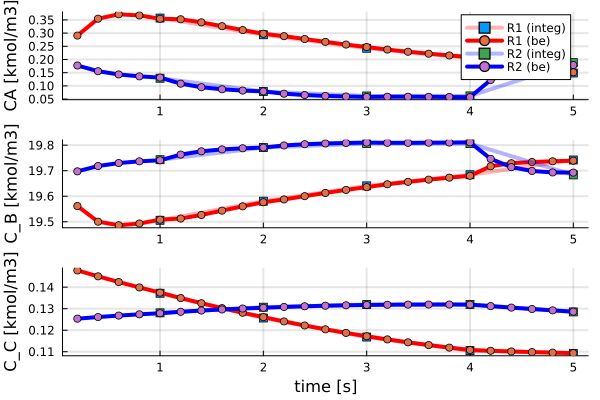

In [23]:
gr()

p11 = plot(t_integr,Cr_CL_integr[1,1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="CA [kmol/m3]")
p11 = plot!(t_be,Cr_CL_be[1,1,:],linewidth=4,linecolor = :red,marker=:circle)
p11 = plot!(t_integr,Cr_CL_integr[1,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue)
p11 = plot!(t_be,Cr_CL_be[1,2,:],linewidth=4,linecolor = :blue,marker=:circle)

p11.series_list[1][:label] = "R1 (integ)"
p11.series_list[2][:label] = "R1 (be)"
p11.series_list[3][:label] = "R2 (integ)"
p11.series_list[4][:label] = "R2 (be)"

p12 = plot(t_integr,Cr_CL_integr[2,1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="C_B [kmol/m3]",legend=false)
p12 = plot!(t_be,Cr_CL_be[2,1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p12 = plot!(t_integr,Cr_CL_integr[2,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p12 = plot!(t_be,Cr_CL_be[2,2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

p13 = plot(t_integr,Cr_CL_integr[3,1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="C_C [kmol/m3]",legend=false)
p13 = plot!(t_be,Cr_CL_be[3,1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p13 = plot!(t_integr,Cr_CL_integr[3,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p13 = plot!(t_be,Cr_CL_be[3,2,:],linewidth=4,linecolor = :blue,marker=:circle,xaxis="time [s]",legend=false)

g6 = plot(p11,p12,p13,layout=(3,1))
display(g6)

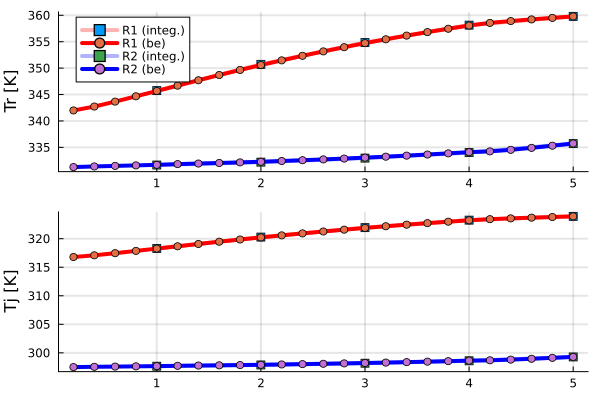

In [24]:
gr()

p14 = plot(t_integr,Tr_CL_integr[1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Tr [K]")
p14 = plot!(t_be,Tr_CL_be[1,:],linewidth=4,linecolor = :red,marker=:circle)
p14 = plot!(t_integr,Tr_CL_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue)
p14 = plot!(t_be,Tr_CL_be[2,:],linewidth=4,linecolor = :blue,marker=:circle)

p14.series_list[1][:label] = "R1 (integ.)"
p14.series_list[2][:label] = "R1 (be)"
p14.series_list[3][:label] = "R2 (integ.)"
p14.series_list[4][:label] = "R2 (be)"

p15 = plot(t_integr,Tj_CL_integr[1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="Tj [K]",legend=false)
p15 = plot!(t_be,Tj_CL_be[1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p15 = plot!(t_integr,Tj_CL_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p15 = plot!(t_be,Tj_CL_be[2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

g7 = plot(p14,p15,layout=(2,1))
display(g7)

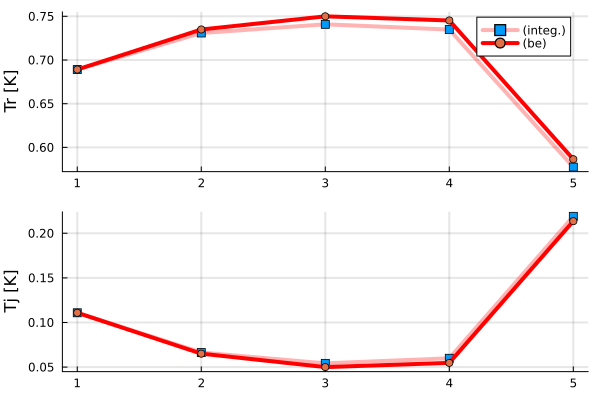

In [25]:
gr()

p16 = plot(t_integr,Q1_CL_integr,linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Tr [K]")
p16 = plot!(t_integr,Q1_CL_be[1,:],linewidth=4,linecolor = :red,marker=:circle)

p16.series_list[1][:label] = "(integ.)"
p16.series_list[2][:label] = "(be)"

p17 = plot(t_integr,Qm_CL_integr,linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="Tj [K]",legend=false)
p17 = plot!(t_integr,Qm_CL_be,linewidth=4,linecolor = :red,marker=:circle,legend=false)

g8 = plot(p16,p17,layout=(2,1))
display(g8)

<a id="sec4"></a>

# Comparing Optimality Gap for Different Relaxation Weights

- Declaring multiscenario problem

In [26]:
# number of scenarios
ns = 3

# Assuming equiprobable scenarios
pScen = 1.0/ns

# creating uncertain parameter array
pTemp = LinRange(Ua[1] - 0.01*0.007,Ua[2] + 0.01*0.007, ns)
UaTemp = [pTemp'; Ua[2]*ones(1,ns)]

# parameter that weights the nominal trajectory tracking term
η_n = 1e-2

# nominal solution
solNom = [351.40668279779777 351.8842663796819 356.3787430006147;
          329.1577286086469 329.8024567878738 330.78524746150003];

# JuMP model
model_ms = Model(Ipopt.Optimizer)
set_optimizer_attribute(model_ms, "warm_start_init_point", "yes")

####################
# Set up variables #
####################
# DRTO model variables
@variable(model_ms, C[1:nc, 1:nrt, 1:nfe, 1:ncp, 1:ns] ≥ 0)           # [kmol/m3] concentration (diff states)
@variable(model_ms, T[rt=1:nrt, 1:nfe, 1:ncp, 1:ns] ≥ Tj_in[rt])      # [K] reactor temperature (diff states)
@variable(model_ms, J[1:nfe, 1:ncp, 1:ns])                            # [$] objective function (diff states)
@variable(model_ms, Cdot[1:nc, 1:nrt, 1:nfe, 1:ncp, 1:ns])            # [kmol/m3/s] concentration (time derivative)
@variable(model_ms, Tdot[1:nrt, 1:nfe, 1:ncp, 1:ns])                  # [K/s] reactor temperature (time derivative)
@variable(model_ms, Jdot[1:nfe, 1:ncp, 1:ns])                         # [$/s] objective function (time derivative
@variable(model_ms, Tj_out[rt=1:nrt, 1:nfe, 1:ncp, 1:ns] ≥ Tj_in[rt]) # [K] reactor temperature (diff states)
@variable(model_ms, C_in[1:nc, 1:nrt, 1:nfe, 1:ncp, 1:ns] ≥ 0)        # [kmol/m3] inlet concentration (alg. states)
@variable(model_ms, T_in[rt=1:nrt, 1:nfe, 1:ncp, 1:ns])               # [K] inlet temperature (alg. states)
@variable(model_ms, Q_min ≤ Q[1:nrt, 1:ndrto, 1:ns] ≤ Qf_max)           # [m3/s] flowrate to reactor
@variable(model_ms, Qm_min ≤ Qm[1:ndrto, 1:ns] ≤ Qf_max)                # [m3/s] flowrate to mixer

# MPC model variables (SISO) -> deviation form
@variable(model_ms, xMPC[1:numpc, 1:ndrto, 1:ns])
@variable(model_ms, uMPC[1:numpc, 1:ndrto, 1:m, 1:ns])

# MPC <-> DRTO model deviation
@variable(model_ms, de[1:numpc,1:(ndrto - 1), 1:ns])

# Constrained MPC KKT conditions (upper and lower bounds for each input)
@variable(model_ms, mu_g[1:numpc,1:ndrto,1:(2*m), 1:ns] ≥ 0.0) 

# relaxing cc's
@variable(model_ms, delta_c1_ccub[1:ndrto,1:m, 1:ns] ≥ 0.0)
@variable(model_ms, delta_c1_cclb[1:ndrto,1:m, 1:ns] ≥ 0.0)
@variable(model_ms, delta_c2_ccub[1:ndrto,1:m, 1:ns] ≥ 0.0)
@variable(model_ms, delta_c2_cclb[1:ndrto,1:m, 1:ns] ≥ 0.0)

# setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
@variable(model_ms, yspMin[nct] ≤ ysp[nct = 1:numpc,1:ndrto, 1:ns] ≤ yspMax[nct])

# non-anticipativity constraints
@variable(model_ms, yspMin[nct] ≤ yspNA[nct = 1:numpc,1:Δdrto] ≤ yspMax[nct])

#####################################
# Set up initial guesses for solver #
#####################################
# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for ss in 1:ns
    for kk in 1:nfe
        for jj in 1:ncp
            for rr in 1:nrt
                for cc in 1:nc
                    # concentration related variables
                    set_start_value(C[cc,rr,kk,jj,ss], C0_star[cc,rr]) 
                end # components loop

                # temperature related variables
                set_start_value(T[rr,kk,jj,ss], T0_star[rr]) 
                set_start_value(T_in[rr,kk,jj,ss], T_in0_star[rr])
                set_start_value(Tj_out[rr,kk,jj,ss], Tj_out0_star[rr])

            end # reactors loop
        end # collocation points loop
    end # finite elements loop

    for kk in 1:ndrto
        # MV's
        for rr in 1:nrt
            set_start_value(Q[rr,kk,ss], Q0_star[rr])  
        end
        set_start_value(Qm[kk,ss], Qm0_star) 

        for mm in 1:m
            set_start_value(uMPC[1,kk,mm,ss], Q0_star[1] - uref[1])
            set_start_value(uMPC[2,kk,mm,ss], Qm0_star - uref[2])
        end
    end # drto sampling time loop
end # scenarios loop
    
##############
# DRTO model #
##############
@NLexpressions(model_ms, begin
        # [1/s] reaction rate
        k[rt = 1:nrt, rc = 1:nrc, kk = 1:nfe, jj = 1:ncp, ss = 1:ns], k0[rc]*exp(-ER[rc]/T[rt,kk,jj,ss])
        #[m3 K/s] cooling rate
        # approximate model *approximating logarithm temperature
        qcool[rt = 1:nrt,kk = 1:nfe, jj = 1:ncp, ss = 1:ns], UaTemp[rt,ss]*(T[rt,kk,jj,ss] - (0.5*(Tj_out[rt,kk,jj,ss] + Tj_in[rt])))
end)

@NLconstraints(model_ms, begin
        #########
        # MODEL #
        #########    
        # reactor
        r_cmb[co = 1:nc, rt = 1:nrt, kk = 1:nfe, jj = 1:ncp, ss = 1:ns], Cdot[co,rt,kk,jj,ss] == (C_in[co,rt,kk,jj,ss] - C[co,rt,kk,jj,ss])*Q[rt,cld(kk,n_fe_dt),ss]/V[rt] + sum(Ms[co,rc]*k[rt,rc,kk,jj,ss]*C[rc,rt,kk,jj,ss] for rc in 1:nrc) 
        r_eb[rt = 1:nrt, kk = 1:nfe, jj = 1:ncp, ss = 1:ns], Tdot[rt,kk,jj,ss] == (T_in[rt,kk,jj,ss] - T[rt,kk,jj,ss])*Q[rt,cld(kk,n_fe_dt),ss]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,kk,jj,ss]*C[rc,rt,kk,jj,ss] for rc in 1:nrc) - qcool[rt,kk,jj,ss]/V[rt]
        # mixer
        m_mb[kk = 1:ndrto,ss = 1:ns], 0 == Q[1,kk,ss] + Qm[kk,ss] - Q[2,kk,ss]
        m_cmb[co = 1:nc,kk = 1:nfe,jj = 1:ncp,ss = 1:ns], 0 == Q[1,cld(kk,n_fe_dt),ss]*C[co,1,kk,jj,ss] + Qm[cld(kk,n_fe_dt),ss]*Cm_in[co] - Q[2,cld(kk,n_fe_dt),ss]*C_in[co,2,kk,jj,ss]
        m_eb[kk = 1:nfe,jj = 1:ncp,ss = 1:ns], 0 == Q[1,cld(kk,n_fe_dt),ss]*T[1,kk,jj,ss] + Qm[cld(kk,n_fe_dt),ss]*Tm_in - Q[2,cld(kk,n_fe_dt),ss]*T_in[2,kk,jj,ss]
        # jacket
        j_eb[rt = 1:nrt,kk = 1:nfe,jj = 1:ncp,ss = 1:ns], 0 == Qj_in[rt]*(Tj_out[rt,kk,jj,ss] - Tj_in[rt]) - qcool[rt,kk,jj,ss]
        # objective function
        JInteg[kk = 1:nfe, jj = 1:ncp,ss = 1:ns], Jdot[kk,jj,ss] == 10*(Q[1,cld(kk,n_fe_dt),ss]*C_in[1,1,kk,jj,ss] + Qm[cld(kk,n_fe_dt),ss]*Cm_in[1] - Q[2,cld(kk,n_fe_dt),ss]*(C[1,2,kk,jj,ss] + C[3,2,kk,jj,ss])) - 0.01*qcool[1,kk,jj,ss] - qcool[2,kk,jj,ss] - 0.1*Q[1,cld(kk,n_fe_dt),ss] - 0.1*Qm[cld(kk,n_fe_dt),ss]

        #########################    
        # Collocation Equations #    
        #########################
        # initial point
        coll_C_0[co=1:nc, rt = 1:nrt,ss = 1:ns], C[co,rt,1,1,ss] == C0[co,rt] 
        coll_T_0[rt = 1:nrt,ss = 1:ns], T[rt,1,1,ss] == T0[rt]
        coll_J_0[ss = 1:ns], J[1,1,ss] == 0 

        # set up collocation equations 
        coll_C_n[co = 1:nc, rt = 1:nrt, kk = 1:nfe, jj = 2:ncp,ss = 1:ns], sum(colmat[ii,jj]*C[co,rt,kk,ii,ss] for ii in 1:ncp) - h*Cdot[co,rt,kk,jj,ss] == 0 
        coll_T_n[rt = 1:nrt, kk = 1:nfe, jj = 2:ncp, ss = 1:ns], sum(colmat[ii,jj]*T[rt,kk,ii] for ii in 1:ncp) - h*Tdot[rt,kk,jj,ss] == 0
        coll_J_n[kk = 1:nfe, jj = 2:ncp, ss = 1:ns], sum(colmat[ii,jj]*J[kk,ii,ss] for ii in 1:ncp) - h*Jdot[kk,jj,ss] == 0

        # continuinity equations
        coll_C_con[co = 1:nc, rt = 1:nrt, kk = 2:nfe,ss = 1:ns], C[co,rt,kk,1,ss] - C[co,rt,kk - 1,ncp,ss] == 0 
        coll_T_con[rt = 1:nrt, kk = 2:nfe,ss = 1:ns], T[rt,kk,1,ss] - T[rt,kk - 1,ncp,ss] == 0
        coll_J_con[kk = 2:nfe,ss = 1:ns], J[kk,1,ss] - J[kk - 1,ncp,ss] == 0
end)

##########################
# MPC model and solution #
##########################
# N.B. inside MPC everything is in deviation variables
@expressions(model_ms, begin
        # MPC1
        cfT_c1_1[ss = 1:ns], (mpc1['Ψ']*[xMPC0[1];de_0[1]] .- (ysp[1,1,ss] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - (u0[1] - uref[1])*mpc1['I']'*mpc1['R']*mpc1['M']
        cfT_c1[kk=1:(ndrto - 1),ss = 1:ns], (mpc1['Ψ']*[xMPC[1,kk,ss];de[1,kk,ss]] .- (ysp[1,kk + 1,ss] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - uMPC[1,kk,1,ss]*mpc1['I']'*mpc1['R']*mpc1['M']
        # Input bounds
        MPC1_u_upper[kk = 1:ndrto,uu = 1:m,ss = 1:ns], (uMax[1] - uref[1]) - uMPC[1,kk,uu,ss]
        MPC1_u_lower[kk = 1:ndrto,uu = 1:m,ss = 1:ns], uMPC[1,kk,uu,ss] - (uMin[1] - uref[1])
        # MPC2
        cfT_c2_1[ss = 1:ns], (mpc2['Ψ']*[xMPC0[2];de_0[2]] .- (ysp[2,1,ss] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - (u0[2] - uref[2])*mpc2['I']'*mpc2['R']*mpc2['M']
        cfT_c2[kk=1:(ndrto - 1),ss = 1:ns], (mpc2['Ψ']*[xMPC[2,kk,ss];de[2,kk,ss]] .- (ysp[2,kk + 1,ss] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - uMPC[2,kk,1,ss]*mpc2['I']'*mpc2['R']*mpc2['M']
        # Input bounds
        MPC2_u_upper[kk = 1:ndrto,uu = 1:m,ss = 1:ns], (uMax[2] - uref[2]) - uMPC[2,kk,uu,ss]
        MPC2_u_lower[kk = 1:ndrto,uu = 1:m,ss = 1:ns], uMPC[2,kk,uu,ss] - (uMin[2] - uref[2])    
end)

@constraints(model_ms, begin
        #############
        # MPC model #
        #############
        # MPC1
        MPC1_dyn_model_1[ss = 1:ns], xMPC[1,1,ss] == mpc1['A']*xMPC0[1] + mpc1['B']*uMPC[1,1,1,ss]
        MPC1_dyn_model[kk = 1:(ndrto - 1),ss = 1:ns], xMPC[1,kk + 1,ss] == mpc1['A']*xMPC[1,kk,ss] + mpc1['B']*uMPC[1,kk + 1,1,ss]
        MPC1_model_dev[kk = 1:(ndrto - 1),ss = 1:ns], de[1,kk,ss] == T[1,kk*n_fe_dt,ncp,ss] - (xMPC[1,kk,ss] + yref[1])
        # MPC12
        MPC2_dyn_model_1[ss = 1:ns], xMPC[2,1,ss] == mpc2['A']*xMPC0[2] + mpc2['B']*uMPC[2,1,1,ss]
        MPC2_dyn_model[kk = 1:(ndrto - 1),ss = 1:ns], xMPC[2,kk + 1,ss] == mpc2['A']*xMPC[2,kk,ss] + mpc2['B']*uMPC[2,kk + 1,1,ss]
        MPC2_model_dev[kk = 1:(ndrto - 1),ss = 1:ns], de[2,kk,ss] == T[2,kk*n_fe_dt,ncp,ss] - (xMPC[2,kk,ss] + yref[2])
        ################
        # MPC solution #
        ################
        # MPC 1
        # stationarity
        MPC1_sol_sta_1[ss = 1:ns], uMPC[1,1,:,ss]'*mpc1['H'] + cfT_c1_1[ss] +  mu_g[1,1,:,ss]'*conMatrix .== 0
        MPC1_sol_sta[kk = 1:(ndrto - 1),ss = 1:ns], uMPC[1,kk + 1,:,ss]'*mpc1['H'] + cfT_c1[kk,ss] +  mu_g[1,kk + 1,:,ss]'*conMatrix .== 0
        # primal feasibility
        MPC1_sol_feas_ub[kk = 1:ndrto,uu = 1:m,ss = 1:ns], MPC1_u_upper[kk,uu,ss] ≥ 0
        MPC1_sol_feas_lb[kk = 1:ndrto,uu = 1:m,ss = 1:ns], MPC1_u_lower[kk,uu,ss] ≥ 0
        # dual feasibility (already defined above)
        # complementarity constraint (defined below since it is nonlinear)
        # MPC 2
        # stationarity
        MPC2_sol_sta_1[ss = 1:ns], uMPC[2,1,:,ss]'*mpc2['H'] + cfT_c2_1[ss] +  mu_g[2,1,:,ss]'*conMatrix .== 0
        MPC2_sol_sta[kk = 1:(ndrto - 1),ss = 1:ns], uMPC[2,kk + 1,:,ss]'*mpc2['H'] + cfT_c2[kk,ss] +  mu_g[2,kk + 1,:,ss]'*conMatrix .== 0
        # primal feasibility
        MPC2_sol_feas_ub[kk = 1:ndrto,uu = 1:m,ss = 1:ns], MPC2_u_upper[kk,uu,ss] ≥ 0
        MPC2_sol_feas_lb[kk = 1:ndrto,uu = 1:m,ss = 1:ns], MPC2_u_lower[kk,uu,ss] ≥ 0
        # dual feasibility (already defined above)
        # complementarity constraint (defined below since it is nonlinear)      
end)

@NLconstraints(model_ms, begin
        # MPC 1 
        # complementarity constraint
        MPC1_sol_cc_ub[kk = 1:ndrto,uu = 1:m,ss = 1:ns], mu_g[1,kk,uu,ss]*MPC1_u_upper[kk,uu,ss] == delta_c1_ccub[kk,uu,ss]
        MPC1_sol_cc_lb[kk = 1:ndrto,uu = 1:m,ss = 1:ns], mu_g[1,kk,m + uu,ss]*MPC1_u_lower[kk,uu,ss] == delta_c1_cclb[kk,uu,ss]    

        # MPC 2
        # complementarity constraint
        MPC2_sol_cc_ub[kk = 1:ndrto,uu = 1:m,ss = 1:ns], mu_g[2,kk,uu,ss]*MPC2_u_upper[kk,uu,ss] == delta_c2_ccub[kk,uu,ss]
        MPC2_sol_cc_lb[kk = 1:ndrto,uu = 1:m,ss = 1:ns], mu_g[2,kk,m + uu,ss]*MPC2_u_lower[kk,uu,ss] == delta_c2_cclb[kk,uu,ss] 
end)

@constraints(model_ms, begin   
        #######################
        # PROCESS CONSTRAINTS #
        #######################
        # ! Enforcing only at the end of the finite element
        # safety restrictions
        g1[rt = 1:nrt, kk = 1:nfe,ss = 1:ns], T[rt,kk,ncp,ss] - Tr_max ≤ 0
        # product specifications (Concentration of A in reactor 2)
        g2[kk = 1:nfe,ss = 1:ns], C[1,2,kk,ncp,ss] - cA2_max ≤ 0
        # feed supply limitations
        g3[kk = 1:ndrto,ss = 1:ns], Q[1,kk,ss] + Qm[kk,ss] - Qf_max ≤ 0
        # process limitations (others have been included when declaring variables): max cooling water outlet temperature
        g4[rt = 1:nrt, kk = 1:nfe,ss = 1:ns], Tj_out[rt,kk,ncp,ss] - Tj_max[rt] ≤ 0    
        ############################
        # OPTIMIZATION CONSTRAINTS #
        ############################
        # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
        h1[kk = 1:ndrto,ss = 1:ns], (uMPC[1,kk,1,ss] + uref[1]) - Q[1,kk,ss] == 0
        h2[kk = 1:ndrto,ss = 1:ns], (uMPC[2,kk,1,ss] + uref[2]) - Qm[kk,ss] == 0
        ##################################
        # NON-ANTICIPATIVITY CONSTRAINTS #
        ##################################
        nonAnt_c1[kk=1:Δdrto,ss=1:ns], ysp[1,kk,ss] - yspNA[1,kk] == 0.0
        nonAnt_c2[kk=1:Δdrto,ss=1:ns], ysp[2,kk,ss] - yspNA[2,kk] == 0.0
        ##############    
        # PARAMETERS #
        ##############
        p1[co = 1:nc,kk = 1:nfe,jj = 1:ncp,ss = 1:ns], C_in[co,1,kk,jj,ss] - C1_in[co] == 0
        p2[kk = 1:nfe,jj = 1:ncp,ss = 1:ns], T_in[1,kk,jj,ss] - T1_in == 0
    end);

Testing different values for $\rho_{cc}$

In [33]:
# trial weights for slack OF term
rho_cc_Array = [1e0 1e1 5e1 1e2 2e2 5e2 1e3] 
#rho_cc_Array = [5e1 6e1 7e1 8e1] 

# rho_cc_Array = [1e0 1e1 5e1 1e2] 

nTest = length(rho_cc_Array)

# for ploting
# checking the complementarities for 3 scenarios
comp_gap_s3 = Matrix{Float64}(undef,ns,nTest) 

# for future work (approximating cc with binaries) -> checking the upper bound of the MPC KKT problem multipliers
mu_max_s3 = Vector{Float64}(undef,nTest)

for ii = 1:nTest
    display("rho_cc = $(rho_cc_Array[ii]) >> Iteration: $(ii)")
    
    # solving problem with relaxed complementarity slackness
    # Modifying OF of the original problem  
    rhoTemp = [rho_cc_Array[ii] rho_cc_Array[ii] rho_cc_Array[ii]]
    @NLobjective(model_ms, Min, pScen*sum(-J[nfe,ncp,ss] + rhoTemp[ss]*sum(
                    sum(delta_c1_ccub[kk,uu,ss] + delta_c1_cclb[kk,uu,ss] + 
                    delta_c2_ccub[kk,uu,ss] + delta_c2_cclb[kk,uu,ss] for uu in 1:m)
                    for kk in 1:ndrto)
                    for ss in 1:ns) + 
                    η_n*sum(sum((yspNA[nct,kk] - solNom[nct,kk])^2 for nct = 1:numpc) for kk in 1:Δdrto)) #DB

        
    # solving problem
    optimize!(model_ms)

    #calling values of the solved problem
    mu_sol = value.(mu_g)
    mpc1_u_sol = value.(delta_c1_ccub)
    mpc1_l_sol = value.(delta_c1_cclb)
    mpc2_u_sol = value.(delta_c2_ccub)
    mpc2_l_sol = value.(delta_c2_cclb)
   
    # checking the complementarity gap
    for ss in 1:ns
        comp_gap_s3[ss,ii] = abs(sum(mpc1_u_sol[kk,uu,ss] + mpc1_l_sol[kk,uu,ss] + 
                mpc2_u_sol[kk,uu,ss] + mpc2_l_sol[kk,uu,ss] for kk in 1:ndrto, uu in 1:m))
    end
    
    # checking the upper doung
    mu_max_s3[ii] = maximum(mu_sol)
end  

"rho_cc = 1.0 >> Iteration: 1"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18543
Number of nonzeros in inequality constraint Jacobian.:      585
Number of nonzeros in Lagrangian Hessian.............:    17796

Total number of variables............................:     4785
                     variables with only lower bounds:     2760
                variables with lower and upper bounds:       81
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4587
Total number of inequality constraints...............:      570
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      390

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4813250e+03 7.70e+03 5.11e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"rho_cc = 10.0 >> Iteration: 2"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18543
Number of nonzeros in inequality constraint Jacobian.:      585
Number of nonzeros in Lagrangian Hessian.............:    17796

Total number of variables............................:     4785
                     variables with only lower bounds:     2760
                variables with lower and upper bounds:       81
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4587
Total number of inequality constraints...............:      570
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      390

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4867250e+03 7.70e+03 5.11e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"rho_cc = 50.0 >> Iteration: 3"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18543
Number of nonzeros in inequality constraint Jacobian.:      585
Number of nonzeros in Lagrangian Hessian.............:    17796

Total number of variables............................:     4785
                     variables with only lower bounds:     2760
                variables with lower and upper bounds:       81
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4587
Total number of inequality constraints...............:      570
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      390

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5107250e+03 7.70e+03 1.67e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"rho_cc = 100.0 >> Iteration: 4"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18543
Number of nonzeros in inequality constraint Jacobian.:      585
Number of nonzeros in Lagrangian Hessian.............:    17796

Total number of variables............................:     4785
                     variables with only lower bounds:     2760
                variables with lower and upper bounds:       81
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4587
Total number of inequality constraints...............:      570
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      390

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5407249e+03 7.70e+03 3.33e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"rho_cc = 200.0 >> Iteration: 5"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18543
Number of nonzeros in inequality constraint Jacobian.:      585
Number of nonzeros in Lagrangian Hessian.............:    17796

Total number of variables............................:     4785
                     variables with only lower bounds:     2760
                variables with lower and upper bounds:       81
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4587
Total number of inequality constraints...............:      570
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      390

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.6007249e+03 7.70e+03 6.67e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"rho_cc = 500.0 >> Iteration: 6"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18543
Number of nonzeros in inequality constraint Jacobian.:      585
Number of nonzeros in Lagrangian Hessian.............:    17796

Total number of variables............................:     4785
                     variables with only lower bounds:     2760
                variables with lower and upper bounds:       81
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4587
Total number of inequality constraints...............:      570
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      390

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7807247e+03 7.70e+03 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"rho_cc = 1000.0 >> Iteration: 7"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    18543
Number of nonzeros in inequality constraint Jacobian.:      585
Number of nonzeros in Lagrangian Hessian.............:    17796

Total number of variables............................:     4785
                     variables with only lower bounds:     2760
                variables with lower and upper bounds:       81
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4587
Total number of inequality constraints...............:      570
        inequality constraints with only lower bounds:      180
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      390

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.0807244e+03 7.70e+03 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

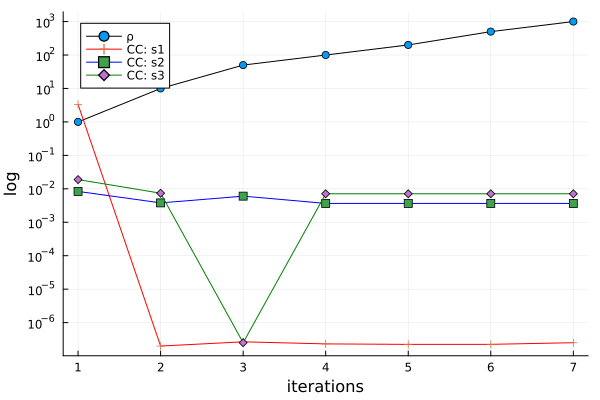

In [35]:
gr()

# preparing y ticks
y_ti = [10.0^ii for ii in -6:3]

p18 = plot(1:nTest,rho_cc_Array', yaxis="log",xaxis="iterations",linecolor = :black,marker= :circle,
            xticks = 1:nTest,legend=:topleft,yscale=:log10,yticks = y_ti)
p18 = plot!(1:nTest,comp_gap_s3[1,:], linecolor = :red,marker= :cross,xticks = 1:nTest,yscale=:log10,legend=:topleft)
p18 = plot!(1:nTest,comp_gap_s3[2,:], linecolor = :blue,marker= :rect,xticks = 1:nTest,yscale=:log10,legend=:topleft)
p18 = plot!(1:nTest,comp_gap_s3[3,:], linecolor = :green,marker= :diamond,xticks = 1:nTest,yscale=:log10,legend=:topleft)

p18.series_list[1][:label] = "ρ"
p18.series_list[2][:label] = "CC: s1"
p18.series_list[3][:label] = "CC: s2"
p18.series_list[4][:label] = "CC: s3"

display(p18)

In [29]:
display(comp_gap_s3[2,:])

4-element Vector{Float64}:
 0.00603569991914985
 2.6135626255679446e-7
 0.0066982009492300675
 0.00010285967702719356

In [30]:
display(mu_max_s3)

4-element Vector{Float64}:
 741.4069602818283
 250.1387886894252
 297.900045556258
 543.116491373301